<h1> Possum Regression </h1>
https://www.kaggle.com/datasets/abrambeyer/openintro-possum?datasetId=1534513&sortBy=voteCount
<h2> Introduction </h2>

An objective of this work is to consolidate and use part of the knowledge gained from the book "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow".

Our goal is to predict the age of given possum. The problem is supervised and multiple regression type. I will use batch learning, because there is no particular need to adjust to changing data rapidly, the dataset is small and there is no continous stream of data coming.

Root Mean Square Error (RMSE) as a performance measure is a common cost function in regression tasks, so that will be my choice.

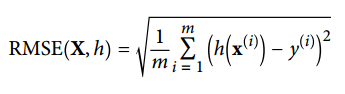

<h2> Libraries and settings</h2>

In [149]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy import stats
from scipy.stats import wasserstein_distance
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from pprint import pprint

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor

%run ml_functions.ipynb
%run custom_transformers.ipynb

np.random.seed(42)

<h2>Load the data <h2>

In [2]:
df = pd.read_csv('data/possum.csv')

<h3> Take a quick look </h3>

In [3]:
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [4]:
df.columns

Index(['case', 'site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth',
       'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')

In [5]:
df.shape

(104, 14)

There are 14 attributes including one dependent variable - 'age' and 104 instances. It means dataset is very small by ML standards.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


<h3>Some at first glance data cleaning</h3>

In column 'age' 2 entries are missing and in column footlngth 1 entry is missing. There are no missing values in other columns. Because the gaps in the data are insignificant, we are not doing anything about it at the moment.

10 of columns are float-type. Columns of object-type are: Pop, sex. Columns of int-type are: case, site. from a dataset description we know in real that Pop, sex and site are categorical attributes.

In [7]:
df["Pop"] = df["Pop"].astype('category')
df["sex"] = df["sex"].astype('category')
df["site"] = df["site"].astype('category')

We can also change 'Pop' name column to 'pop', which fits better to other column names.

In [8]:
df = df.rename(columns={"Pop":"pop"})

The next point is, case column is useless, because rows have indexes.

In [9]:
del df["case"]

Now we have 10 float type and 3 category type attributes.

In [10]:
df.head()

,site,pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [11]:
print(df["sex"].value_counts())
print(df["pop"].value_counts())
print(df["site"].value_counts())

m    61
f    43
Name: sex, dtype: int64
other    58
Vic      46
Name: pop, dtype: int64
1    33
7    18
2    13
5    13
6    13
3     7
4     7
Name: site, dtype: int64


We can see that both 'sex' and 'pop' categorical attributes are of a binary type and both values are nearly equally distributed in them. 'site' attribute is a little bit imbalanced.

In [12]:
df.describe()

,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


Summary of the numerical attributes may be useful later.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'hdlngth'}>,
        <AxesSubplot:title={'center':'skullw'}>],
       [<AxesSubplot:title={'center':'totlngth'}>,
        <AxesSubplot:title={'center':'taill'}>,
        <AxesSubplot:title={'center':'footlgth'}>],
       [<AxesSubplot:title={'center':'earconch'}>,
        <AxesSubplot:title={'center':'eye'}>,
        <AxesSubplot:title={'center':'chest'}>],
       [<AxesSubplot:title={'center':'belly'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

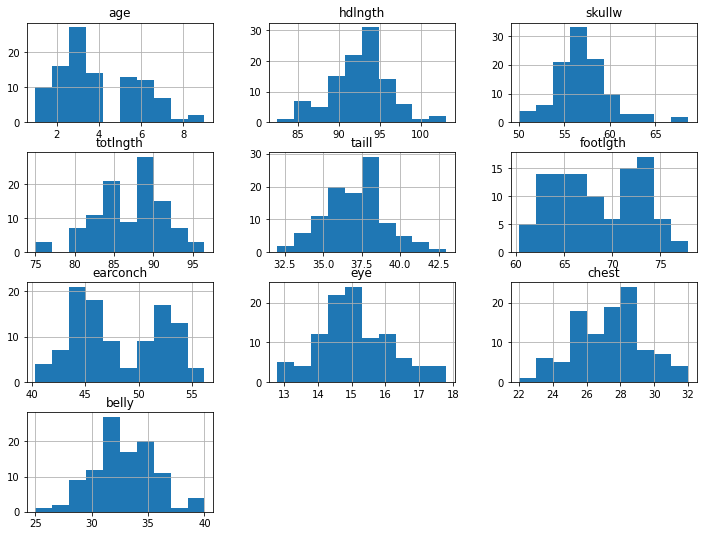

In [13]:
df.hist(figsize=(12,9))

Histograms show us that we shouldn't really be concerned about aspects such as: attributes of very different scales or tail heavy data. However, we will take a better look at these histograms later, during preprocessing process. Additionally, we can see that data doesn't contain outliers, what is one of the factors in favor of changing rmse to another performance measure.

<h3> Test set and training set </h3>

Now, let's check if any of attributes is highly correlated with dependent variable. 

In [14]:
corr_matrix = df.corr()
corr_matrix["age"].sort_values(ascending=False)

age         1.000000
belly       0.354298
chest       0.334209
hdlngth     0.319022
skullw      0.285107
totlngth    0.260280
eye         0.235553
footlgth    0.126190
taill       0.118241
earconch    0.053405
Name: age, dtype: float64

No, there is no high correlation, so we don't need to be aware of sampling bias using standard random sampling.

In [15]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Now we put test_set aside and start working on train_set only.

<h2> Discover and visualize </h2>

<h3> Histograms </h3>

At first, let's deduce something from histograms of the train_set.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'hdlngth'}>,
        <AxesSubplot:title={'center':'skullw'}>],
       [<AxesSubplot:title={'center':'totlngth'}>,
        <AxesSubplot:title={'center':'taill'}>,
        <AxesSubplot:title={'center':'footlgth'}>],
       [<AxesSubplot:title={'center':'earconch'}>,
        <AxesSubplot:title={'center':'eye'}>,
        <AxesSubplot:title={'center':'chest'}>],
       [<AxesSubplot:title={'center':'belly'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

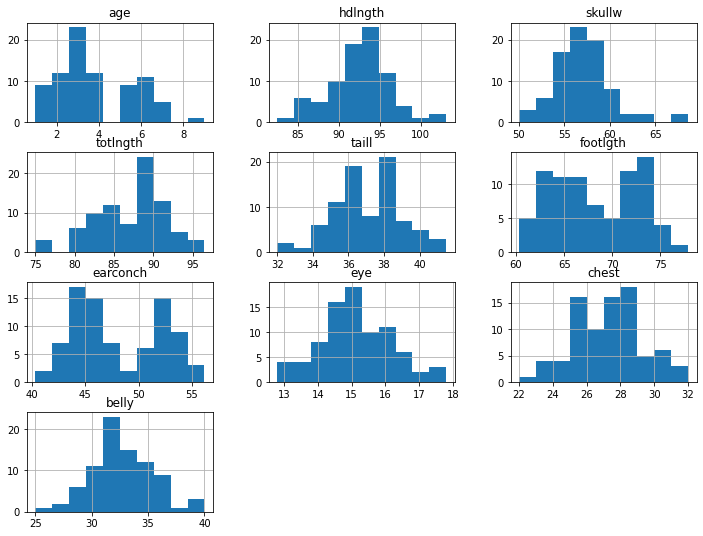

In [16]:
train_set.hist(figsize=(12,9))

Wasserstein distance is a metric in the space of probability measures, which can measure distance between histograms.

In [17]:
columns = train_set.columns

for i in range(len(train_set.columns)):
    if is_numeric_dtype(train_set[train_set.columns[i]]):
        for j in range(i+1,len(train_set.columns)):
            if is_numeric_dtype(train_set[train_set.columns[j]]):
                print('For ', train_set.columns[i], ' and ', train_set.columns[j], 'Wasserstein distance is ', wasserstein_distance(train_set[train_set.columns[i]], train_set[train_set.columns[j]]) )

For  age  and  hdlngth Wasserstein distance is  nan
For  age  and  skullw Wasserstein distance is  nan
For  age  and  totlngth Wasserstein distance is  nan
For  age  and  taill Wasserstein distance is  nan
For  age  and  footlgth Wasserstein distance is  nan
For  age  and  earconch Wasserstein distance is  nan
For  age  and  eye Wasserstein distance is  nan
For  age  and  chest Wasserstein distance is  nan
For  age  and  belly Wasserstein distance is  nan
For  hdlngth  and  skullw Wasserstein distance is  35.628915662650606
For  hdlngth  and  totlngth Wasserstein distance is  5.381927710843373
For  hdlngth  and  taill Wasserstein distance is  55.46265060240963
For  hdlngth  and  footlgth Wasserstein distance is  nan
For  hdlngth  and  earconch Wasserstein distance is  44.42168674698795
For  hdlngth  and  eye Wasserstein distance is  77.43855421686749
For  hdlngth  and  chest Wasserstein distance is  65.55903614457831
For  hdlngth  and  belly Wasserstein distance is  60.046987951807225


Pairs of histograms close to each other are: (hdlngth, totlngth), (taill, belly) and (chest, belly). Potentially we can use this information during feature engineering.

<h3> Correlations </h3>

Let's check a correlation for numeric variables.

In [18]:
train_set.corr()["age"]

age         1.000000
hdlngth     0.254740
skullw      0.192840
totlngth    0.244830
taill       0.098013
footlgth    0.045257
earconch    0.037012
eye         0.220969
chest       0.204392
belly       0.283273
Name: age, dtype: float64

As we can see, correlation levels are very low.

Now, let's check a correlation for categorical attributes (pop, sex, site). Function that we are going to use requires that data has no nans, so let's just drop them for a while.

In [19]:
train_set_new = train_set.copy()

Let's add binary columns that respond columns 'pop' and 'sex'

In [20]:
dummy = pd.get_dummies(train_set_new["pop"])
train_set_new = pd.concat((train_set_new, dummy), axis=1)
del train_set_new["other"]
train_set_new = train_set_new.rename(columns={"Vic":"pop-bin"})

dummy = pd.get_dummies(df["sex"])
train_set_new = pd.concat((train_set_new, dummy), axis=1)
del train_set_new['m']
train_set_new = train_set_new.rename(columns={"f":"sex-bin"})
train_set_new.head()

train_set_new["pop-bin"] = train_set_new["pop-bin"].astype('category')
train_set_new["sex-bin"] = train_set_new["sex-bin"].astype('category')

train_set_new = train_set_new.dropna()
train_set_new.head()

,site,pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,pop-bin,sex-bin
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,1.0,1
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,1.0,1
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,1.0,1
5,1,Vic,f,1.0,93.1,54.8,90.5,35.5,73.2,53.6,14.2,30.0,32.0,1.0,1
6,1,Vic,m,2.0,95.3,58.2,89.5,36.0,71.5,52.0,14.2,30.0,34.5,1.0,0


In [21]:
print(stats.pointbiserialr(train_set_new["pop-bin"], train_set_new["age"]))
print(stats.pointbiserialr(train_set_new["sex-bin"], train_set_new["age"]))

PointbiserialrResult(correlation=0.08370838421598426, pvalue=0.4574990767891822)
PointbiserialrResult(correlation=0.09748964259300605, pvalue=0.38658098861846485)


So even if assumtions of this method are fulfilled, these correlations are not significant.

For a multi categorical attribute we will try ruskal-Wallis H-test.

In [22]:
train_set_new["site"].value_counts()

1    25
7    13
5    11
6    11
2     9
3     6
4     6
Name: site, dtype: int64

In [23]:
group = [None] * 7

for i in range(1,8):
    group[i-1] = train_set_new[["age"]].where(train_set_new["site"] == i).dropna()["age"].tolist()
    print(stats.kruskal(group[i-1], train_set_new["age"]))

KruskalResult(statistic=0.3395172088593224, pvalue=0.5601080307426141)
KruskalResult(statistic=0.1417795109924597, pvalue=0.7065183074614497)
KruskalResult(statistic=0.561735433647231, pvalue=0.4535618539169247)
KruskalResult(statistic=2.005456853621326, pvalue=0.15673406872991036)
KruskalResult(statistic=1.2790622918879813, pvalue=0.2580734590616538)
KruskalResult(statistic=0.008454874681601976, pvalue=0.9267374535850667)
KruskalResult(statistic=1.136838159720179, pvalue=0.28632143298397716)


Since for every group p-value is less than 0.05, we don't reject the null hypothesis that the median of group is same as in train_set for each group. So, we can expect that, site-grouping does not explain the variance to a great extent, hence correlation is low.

<h3> Attribute Combinations </h3>

Since we have only 9 attributes describing possums body, let's just compute ratios between them.

In [24]:
train_set_new = train_set.copy()

body_columns = ['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

for i in range(9):
    for j in range(i+1,9):
        new_column = body_columns[i] + " / " + body_columns[j]
        train_set_new[new_column] = train_set_new[body_columns[i]] / train_set_new[body_columns[j]]

In [25]:
corr_matrix = train_set_new.corr()
corr_matrix["age"].sort_values(ascending=False)

age                    1.000000
belly                  0.283273
hdlngth                0.254740
totlngth               0.244830
eye                    0.220969
chest                  0.204392
skullw                 0.192840
totlngth / footlgth    0.162309
totlngth / taill       0.147566
hdlngth / footlgth     0.141474
skullw / footlgth      0.120056
totlngth / earconch    0.099592
taill                  0.098013
hdlngth / earconch     0.087937
skullw / earconch      0.084262
hdlngth / taill        0.083814
skullw / taill         0.081666
footlgth               0.045257
earconch               0.037012
taill / footlgth       0.025634
taill / earconch       0.018716
hdlngth / skullw      -0.024388
skullw / totlngth     -0.024991
totlngth / eye        -0.027085
eye / chest           -0.028092
footlgth / earconch   -0.034156
skullw / eye          -0.051047
hdlngth / totlngth    -0.057181
hdlngth / eye         -0.068390
totlngth / chest      -0.074794
eye / belly           -0.091034
skullw /

Again, correlations are on very low level.

<h2> Prepare the data for ML algorithms </h2>
<h3> Data Cleaning </h3>

In [26]:
train_set_new = train_set.drop("age", axis=1)
train_set_labels = train_set["age"].copy()

Since most ML algorithms cannot deal with missing values and we are not sure that there won't be any missing values in new data, let's take a stretegy to replace numerical missing instances with the median of an attribute.

In [27]:
imputer = SimpleImputer(strategy='median')
train_set_new_num = train_set_new.drop(["site", "pop", "sex"], axis=1)
imputer.fit(train_set_new_num)
X = imputer.transform(train_set_new_num)
train_set_new_transformed = pd.DataFrame(X, columns=train_set_new_num.columns)

train_set_new_transformed.isnull().values.any()

False

Since ML algorithms prefer to work with number rather than with categogorical attributes, we will convert them to numerical.

In [28]:
train_set_new_cat = train_set_new[["site", "pop", "sex"]]
cat_encoder = OneHotEncoder()

train_set_new_cat_encoded = cat_encoder.fit_transform(train_set_new_cat)

train_set_new_cat_encoded = train_set_new_cat_encoded.toarray()

In [29]:
cat_encoder.categories_

[array([1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array(['Vic', 'other'], dtype=object),
 array(['f', 'm'], dtype=object)]

Let's create a Pipeline, to hold our transformations in more readable way. Despite the fact that, our data is very good scaled, we can additionaly do standarization, beacuse dataset is very small and it cost almost no time.

In [30]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', RatioAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

num_attribs = list(train_set_new_num.columns)
cat_attribs = ["site", "pop", "sex"]

pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])

Now, we will use it.

In [31]:
train_set_new_ready = pipeline.fit_transform(train_set_new)
train_set_new_ready.shape

(83, 56)

We finished this section with set that contains 56 columns, ready to put into ML algorithm.

<h2> Select and train a model </h2>
<h3> This part of the project has been moved to a file named model_selection.ipynb </h3>

<h2> Bibliography </h2>

https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

https://scikit-learn.org/stable/supervised_learning.html

https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error